<a href="https://colab.research.google.com/github/mdaugherity/Unfolding/blob/main/Unfold_Toy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://colab.research.google.com/drive/13obnvuSjVGmO2ebJFiIkYHTVbeYWLjtG#scrollTo=obY4PNlzmvh7

Original

In [1]:
!pip install uproot
!pip install latex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.9/332.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 618.4/618.4 kB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for latex: filename=latex-0.7.0-py3-none-any.whl size=7587 sha256=a7100a36878bb3ac5dfc2500b803694b9400dbf6e9af9b26196f8c43d4f0f5d4
  Stored in directory: /root/.cache/pip/wheels/7e/02/25/c00dfc203e8ba53dfc2e4e97d40e537263d6e03606681f3872
  Created wheel for data: filename=data-0.4-py3-none-any.whl size=7227 sha256=5bacd50c7581c18bd1f9c629cd457c69f9b5c3eecf9d9fb0eda9e6252ffc28bb


In [2]:
from __future__ import absolute_import, division, print_function
import latex
import numpy as np
from numpy import genfromtxt
import matplotlib
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.layers import Dense, Input, concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping
# import BatchNormalization
#from keras.layers.normalization import BatchNormalization

import uproot




In [3]:
Epochs0 = 50
iterations = 3


plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': False
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2 = {'alpha': 0.5, 'density': False}

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#get root data
# /content/drive/MyDrive/Colab Notebooks/STAR Unfolding/jet_spectrum_omni_test.root
with uproot.open("/content/drive/MyDrive/Colab Notebooks/STAR Unfolding/jet_spectrum_omni_test.root") as file:
    nat_truth_root = file['tree_nat/nat_pt_gen'].array()
    nat_data_root = file['tree_nat/nat_pt_smear'].array()
    syn_truth_root = file['tree_syn/syn_pt_gen'].array()
    syn_data_root = file['tree_syn/syn_pt_smear'].array()

In [7]:
#number of raw events
N=len(nat_truth_root)

nat_truth = np.array([(nat_truth_root[i]) for i in range(N)])
nat_data = np.array([(nat_data_root[i]) for i in range(N)])
syn_truth = np.array([(syn_truth_root[i]) for i in range(N)])
syn_data = np.array([(syn_data_root[i]) for i in range(N)])





#bins for ploting
bins_pt = np.linspace(0, 130, 261)
bins_pt_0 = np.linspace(0, 40, 81)
bins_eta = np.linspace(-1, 1.1, 105)
bins_phi = np.linspace(-3.2, 3.2, 86)



#define synthetic and natural initial weights
Synthetic_W = np.ones(N)
Natural_W = np.ones(N)





xvals_1 = np.concatenate((syn_data, nat_data))
yvals_1 = np.concatenate((np.zeros(len(syn_data)), np.ones(len(nat_data))))

xvals_2 = np.concatenate((syn_truth, syn_truth))
yvals_2 = np.concatenate((np.zeros(len(syn_truth)), np.ones(len(syn_truth))))

weights = np.empty(shape=(iterations, 2, len(syn_truth)))







inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model = Model(inputs=inputs, outputs=outputs)



earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)

# from NN (DCTR)
def reweight(events):
    f = model.predict(events, batch_size=5000)
    weights = f / (1. - f+10**-50)
    #return np.clip(np.squeeze(np.nan_to_num(weights)),10**-5,10**7)
    return np.squeeze(np.nan_to_num(weights))


# initial iterative weights are ones
weights_pull = np.ones(len(syn_data))
weights_push = np.ones(len(syn_data))


for i in range(iterations):
    print("\nITERATION: {}\n".format(i + 1))

    # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
    # weights reweighted Sim. --> Data
    print("STEP 1\n")

    weights_1 = np.concatenate((weights_push , Natural_W))
    # actual weights for Sim., ones for Data (not MC weights)

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1)





    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'],
                  weighted_metrics=['accuracy'])
    model.fit(X_train_1,
              Y_train_1,
              sample_weight=w_train_1,
              epochs=Epochs0,
              batch_size=5000,
              validation_data=(X_test_1, Y_test_1, w_test_1),
              callbacks=[earlystopping],
              verbose=1)

    weights_pull = weights_push * reweight(syn_data)



    weights[i, :1, :] = weights_pull

    # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
    # weights Gen. --> reweighted Gen.
    print("\nSTEP 2\n")


    weights_2 = np.concatenate((Synthetic_W, weights_pull))




    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)




    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'],
                  weighted_metrics=['accuracy'])
    model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=Epochs0,
              batch_size=5000,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=1)

    weights_push = reweight(syn_truth)*Synthetic_W


    weights[i, 1:2, :] = weights_push


ITERATION: 1

STEP 1

Epoch 1/50
30/30 [==============================] - 16s 498ms/step - loss: 0.6413 - accuracy: 0.5977 - weighted_accuracy: 0.5977 - val_loss: 0.6308 - val_accuracy: 0.6667 - val_weighted_accuracy: 0.6667
Epoch 2/50
30/30 [==============================] - 0s 15ms/step - loss: 0.6284 - accuracy: 0.6637 - weighted_accuracy: 0.6637 - val_loss: 0.6227 - val_accuracy: 0.6614 - val_weighted_accuracy: 0.6614
Epoch 3/50
30/30 [==============================] - 0s 16ms/step - loss: 0.6236 - accuracy: 0.6594 - weighted_accuracy: 0.6594 - val_loss: 0.6201 - val_accuracy: 0.6560 - val_weighted_accuracy: 0.6560
Epoch 4/50
30/30 [==============================] - 0s 16ms/step - loss: 0.6209 - accuracy: 0.6611 - weighted_accuracy: 0.6611 - val_loss: 0.6163 - val_accuracy: 0.6642 - val_weighted_accuracy: 0.6642
Epoch 5/50
30/30 [==============================] - 0s 16ms/step - loss: 0.6175 - accuracy: 0.6651 - weighted_accuracy: 0.6651 - val_loss: 0.6136 - val_accuracy: 0.6666 - 

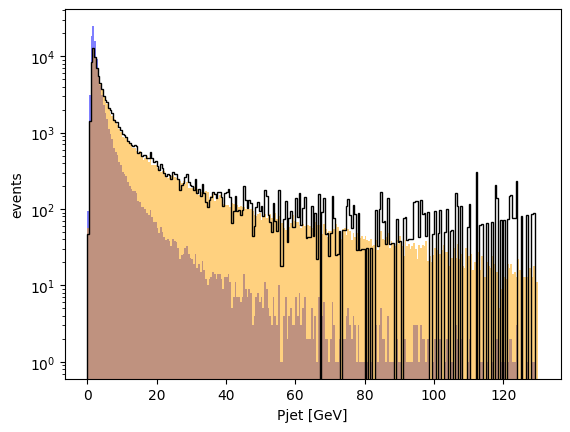

In [8]:

plt.hist(syn_data, weights = Synthetic_W, bins=bins_pt, color='blue',alpha=0.5,label="Synthetic, data")
plt.hist(nat_data, weights = Natural_W, bins=bins_pt, color='orange',alpha=0.5,label="Nature, data")
plt.hist(syn_data, weights = weights[0, 0, :], bins=bins_pt, color='black',histtype="step",label="OmniFolded")
plt.xlabel('Pjet [GeV]')
plt.ylabel('events')
plt.yscale('log')
plt.legend
plt.show()

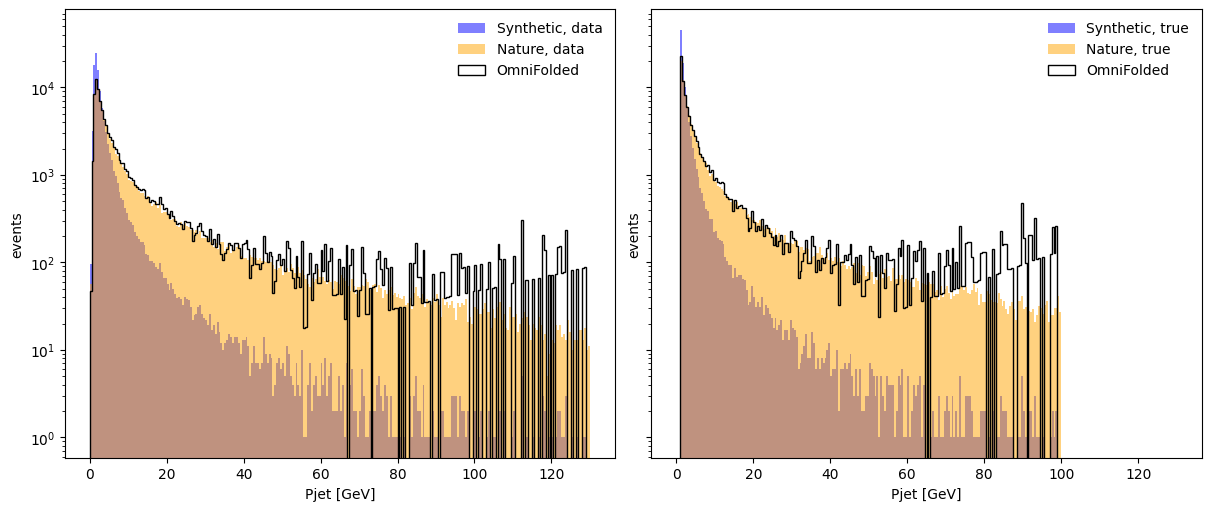

In [9]:
fig, ax = plt.subplots(1,
                           2,
                           figsize=(12, 5),
                           constrained_layout=True,
                           sharey=True)
ax[0].hist(syn_data, weights = Synthetic_W, bins=bins_pt, color='blue',alpha=0.5,label="Synthetic, data")
ax[0].hist(nat_data, weights = Natural_W, bins=bins_pt, color='orange',alpha=0.5,label="Nature, data")
ax[0].hist(syn_data, weights = weights[0, 0, :], bins=bins_pt, color='black',histtype="step",label="OmniFolded")
ax[0].set_xlabel('Pjet [GeV]')
ax[0].set_ylabel('events')
ax[0].set_yscale('log')
legend = ax[0].legend(
    loc='upper right',
    frameon=False)
ax[1].hist(syn_truth, weights = Synthetic_W, bins=bins_pt, color='blue',alpha=0.5,label="Synthetic, true")
ax[1].hist(nat_truth, weights = Natural_W, bins=bins_pt, color='orange',alpha=0.5,label="Nature, true")
ax[1].hist(syn_truth, weights = weights[0, 1, :], bins=bins_pt, color='black',histtype="step",label="OmniFolded")
ax[1].set_xlabel('Pjet [GeV]')
ax[1].set_ylabel('events')
ax[1].set_yscale('log')
legend = ax[1].legend(
    loc='upper right',
    frameon=False)
fig.show()

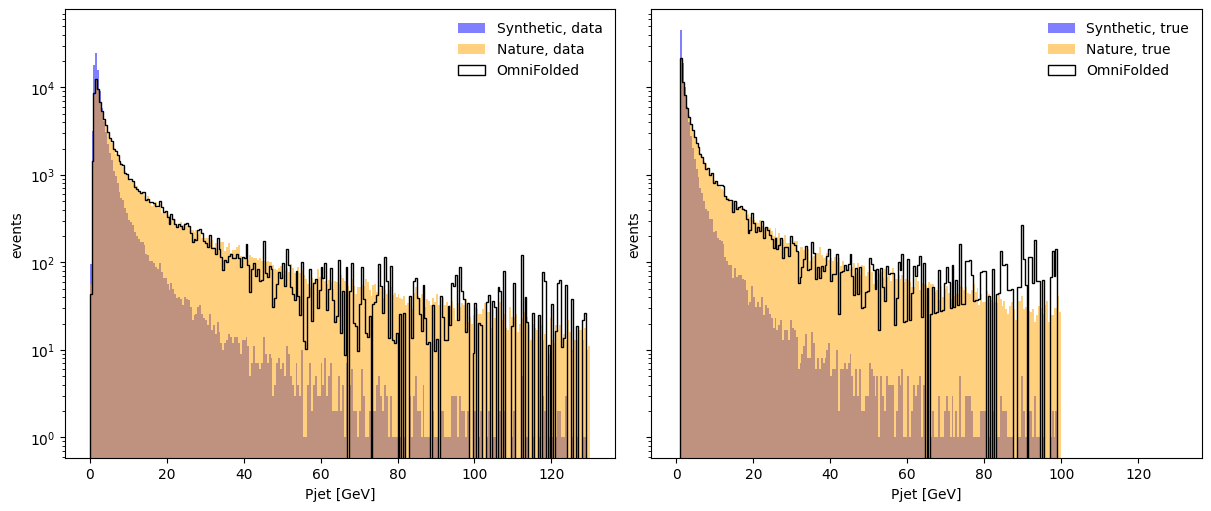

In [10]:
fig, ax = plt.subplots(1,
                           2,
                           figsize=(12, 5),
                           constrained_layout=True,
                           sharey=True)
ax[0].hist(syn_data, weights = Synthetic_W, bins=bins_pt, color='blue',alpha=0.5,label="Synthetic, data")
ax[0].hist(nat_data, weights = Natural_W, bins=bins_pt, color='orange',alpha=0.5,label="Nature, data")
ax[0].hist(syn_data, weights = weights[1, 0, :], bins=bins_pt, color='black',histtype="step",label="OmniFolded")
ax[0].set_xlabel('Pjet [GeV]')
ax[0].set_ylabel('events')
ax[0].set_yscale('log')
legend = ax[0].legend(
    loc='upper right',
    frameon=False)
ax[1].hist(syn_truth, weights = Synthetic_W, bins=bins_pt, color='blue',alpha=0.5,label="Synthetic, true")
ax[1].hist(nat_truth, weights = Natural_W, bins=bins_pt, color='orange',alpha=0.5,label="Nature, true")
ax[1].hist(syn_truth, weights = weights[1, 1, :], bins=bins_pt, color='black',histtype="step",label="OmniFolded")
ax[1].set_xlabel('Pjet [GeV]')
ax[1].set_ylabel('events')
ax[1].set_yscale('log')
legend = ax[1].legend(
    loc='upper right',
    frameon=False)
fig.show()

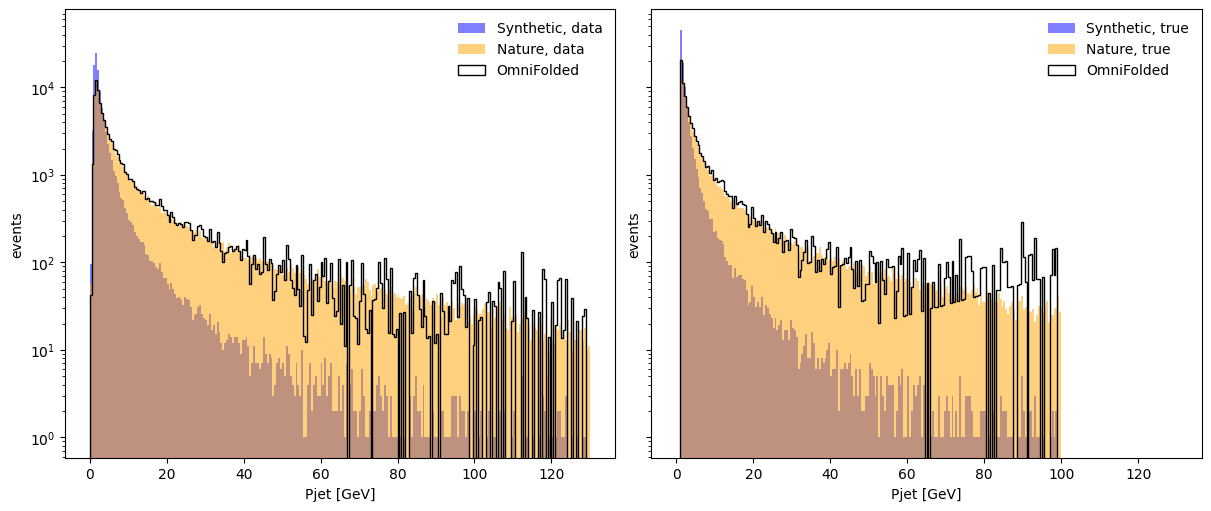

In [11]:
fig, ax = plt.subplots(1,
                           2,
                           figsize=(12, 5),
                           constrained_layout=True,
                           sharey=True)
ax[0].hist(syn_data, weights = Synthetic_W, bins=bins_pt, color='blue',alpha=0.5,label="Synthetic, data")
ax[0].hist(nat_data, weights = Natural_W, bins=bins_pt, color='orange',alpha=0.5,label="Nature, data")
ax[0].hist(syn_data, weights = weights[2, 0, :], bins=bins_pt, color='black',histtype="step",label="OmniFolded")
ax[0].set_xlabel('Pjet [GeV]')
ax[0].set_ylabel('events')
ax[0].set_yscale('log')
legend = ax[0].legend(
    loc='upper right',
    frameon=False)
ax[1].hist(syn_truth, weights = Synthetic_W, bins=bins_pt, color='blue',alpha=0.5,label="Synthetic, true")
ax[1].hist(nat_truth, weights = Natural_W, bins=bins_pt, color='orange',alpha=0.5,label="Nature, true")
ax[1].hist(syn_truth, weights = weights[2, 1, :], bins=bins_pt, color='black',histtype="step",label="OmniFolded")
ax[1].set_xlabel('Pjet [GeV]')
ax[1].set_ylabel('events')
ax[1].set_yscale('log')
legend = ax[1].legend(
    loc='upper right',
    frameon=False)
fig.show()